# A4. Epidemic spreading on complex networks
## Epidemic spreading using the SIS model

Monte Carlo simulation of an epidemic spreading dynamics in complex networks, using the SIS model in which each node represents an individual which can be in two possible states: Susceptible (S), i.e., healthy but can get infected; Infected (I), i.e., has the disease and can spread it to its neighbors.

We are interested in the calculation of the fraction of infected nodes, ρ, in the stationary state, as a function of the infection probability of the disease β (at least 51 values between β=0 and β=1, Δβ=0.02), for different values of the recovery probability μ (e.g. 0.1, 0.5, 0.9). Try different undirected networks (e.g., Erdös-Rényi, scale-free, real), different sizes (at least 500 nodes), average degrees, exponents, etc. Do not make all the combinations, about 10 plots ρ(β) are enough.

Optionally (but mandatory if you want to opt to the maximum grade), compare the ρ(β) result from Monte Carlo simulations with the theoretical prediction provided by the Microscopic Markov Chain Approach (MMCA) model.

### The delivery must include:

Source code

Networks used in Pajek format

Results files

Document (in PDF) including:

Short explanations on how have you done the required work (software, decisions, etc.)
Plots, pointing out “all” the parameters of the corresponding simulation.

Monte Carlo simulations may require a lot of computing time, thus it is recommended the use of compiled languages. In general, and mainly if you are using interpreted languages (e.g., python, Matlab, octave, R), first make tests with small networks, few time steps, and few repetitions, before making the definitive simulations.

Observation: in the original paper on MMCA, the modeled SIS dynamic allows for "one-step reinfections", which are not present in our description of the Monte Carlo simulations. Thus, the last term in Eq. (1) of the paper published in Europhys. Lett. must be removed in order that simulation and theoretical model be comparable. For a comparison of dynamics with and without one-step reinfections, please check the paper published in Int. J. Complex Sys. Sci.


In [ ]:
## Imports 
import igraph as ig
import matplotlib.pylab as plt
from termcolor import colored
import numpy as np 
import random
seed1 = np.random.seed(4234)
seed2 = random.seed(4234)

In [ ]:
## reloading 
%load_ext autoreload
%autoreload 2

## Simple SIS Model (NOT FOR THE DELIVERY)

### Defining it 

In [ ]:

## Implementing a simple SIS model with
def sis_infection(susceptible_people:int,       ## Susceptible (S)
                  infected_people:int,          ## Infected    (I)
                  population:int,               ## Population  (N)
                  beta:float,                   ## Transmission Rate prior to change (beta)
                  gamma:float,                  ## Recovery Rate (gamma)
                  n_iterations:int,             ## Number of iterations
                  n_batch:int,                  ## Number of batches
                  verbosity:bool=True,          ## Whether to show every 50th iteration the results 
                  _plot:bool=False) -> list:    ## Whether to plot the final results 
    """
    
    Calculates the SIS model by the following equation: 
    
    INITIAL CONFIGURATION: 
    
    Population  (N) = 100
    Susceptible (S) = N - 1  (100 - 1 = 99)
    Infected    (I) = 1
    
    MODEL: 
    
    For every timeperiod t_{i}, the susceptible and infected populations
    will be recalculated using a set recovery rate ($\gamma$) and a 
    transmission rate prior to change. 
    
    gamma = 0.2 ## recovery rate 
    beta = 0.3  ## transmission rate 
    
    S = (S - beta * S * I/N) + gamma * I
    S = (I - beta * S * I/N) + gamma * I
    
    """
    ## holders 
    sholder = [None] * population
    iholder = [None] * population
    ## text 
    for idx,t in enumerate(range (0, n_iterations)):
        ## update the susceptible population 
        susceptible_people = susceptible_people - (beta * susceptible_people * infected_people / population) + gamma * infected_people
        ## update the infected population 
        infected_people = infected_people + (beta * susceptible_people * infected_people / population) - gamma * infected_people
        ## update the holders 
        sholder[idx] = susceptible_people
        iholder[idx] = infected_people
        ## some feedback
        if verbosity: 
            if t%n_batch == 0:
                it_txt = f"| Iteration = {t} | "
                s_txt = f"Susceptible = {round(susceptible_people,0)} ({susceptible_people/population*100:.2f}%) | "
                i_txt = f"Infected = {round(infected_people,0)} ({infected_people/population*100:.2f}%)|"
                print(it_txt, colored(s_txt, 'green'), colored(i_txt,'red'))
                
    if _plot:
        ## show the plots 
        figure = plt.figure()  ## creating the figure 
        figure.canvas.manager.set_window_title ('SIS model') ## set a title 
        plt.plot(iholder, label='Infected - I(t)') ## plot the I 
        plt.plot(sholder, label='Susceptible - S(t)') ## plot the S 
        plt.legend() ## add legend 
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) ## scientificnotation 
        plt.xlabel('Timepoint (t)') ## labels 
        plt.ylabel('Percentage of Individuals (N in %)') ## labels 
        plt.show()
    ## return the variables 
    return sholder, iholder

### Running it 

In [ ]:
## Initial Population 
N = 1000000
N_ITER = 150
## Number of Susceptible people
S = N - 1
## Number of Infected people 
I = 1
## Parameters 
## Transmission rate prior to change
BETA = 0.5
## Recovery rate
GAMMA = 0.2
## number of batches for feedback 
N_BATCH = 25
## Verbosity 
VERBOSITY = True 
## plotting 
PLOTTING = True
## kwargs
config = {
        "susceptible_people" : S,
        "infected_people"    : I,
        "population"         : N,
        "beta"               : BETA, 
        "gamma"              : GAMMA, 
        "n_iterations"       : N_ITER,
        "n_batch"            : N_BATCH,
        "verbosity"          : VERBOSITY,
        "_plot"              : PLOTTING
        }

## running 
sus, inf = sis_infection(**config)

## Task at hand

### Steps to do: 

0. Implement a simple SIS model [DONE]
1. Perform the SIS modelling on igraph or graph-tools 
2. Implement the Monte Carlo Method for the simulation 
3. Evaluate and average out the results 

#### Read Bibliography Files

In [ ]:
import glob
import pybtex
from pybtex.database.input import bibtex
def load_parse_bib(bib_path:str) -> pybtex.database.BibliographyData:
    """
    Loads the bib files in the directory and returns the given data format
    for the bibliography files. 
    """

    ## start the parser 
    parser = bibtex.Parser()
    ## get the bib files 
    bib_files = glob.glob(bib_path+"/*.bib")
    ## read the files
    bib_data = [parser.parse_file(x) for x in bib_files]
    ## since they are all parsed, we can return the first element 
    ret_bib_data = bib_data[0]
    return ret_bib_data


In [ ]:
from collections import defaultdict
def get_bib_data(path_to_file:str, verbose:bool) -> dict:
    """
    Prints the following information about the citation:
    Title, Journal, Year, Author(s)
    """
    bib_data = load_parse_bib(bib_path = path_to_file)
    holder = defaultdict(dict)
    ## article
    papers = list(bib_data.entries.keys())
    ## info 
    for idx,ids in enumerate(papers):
        c_data = bib_data.entries[ids]
        title = c_data.fields['title']
        journal = c_data.fields['journal']
        year = c_data.fields['year']
        ## authors 
        authors = [" ".join(x.first_names + x.last_names)  for x in c_data.persons['author']][:3]
        ## joined on a string 
        ret_authors = ' '.join((x for x in authors))
        ## update tracker
        holder[idx]['title'] = title
        holder[idx]['journal'] = journal
        holder[idx]['year'] = year
        holder[idx]['author'] = authors[0]
        if verbose:
            print(colored(f'Source {idx+1}','green'))
            print(colored("Title:",attrs=['bold']),f"{title}")
            print(colored("Journal:",attrs=['bold']),f"{journal}")
            print(colored("Year:",attrs=['bold']),f"{year}")
            print(colored("Authors:",attrs=['bold']),f"{ret_authors}\n")
    return holder

In [ ]:
## where the citation (.bib) files are located
CITATIONS = "./citations"
VERBOSITY = True
## returns a dictionary 
info = get_bib_data(path_to_file=CITATIONS,verbose=VERBOSITY)

### SIS Model

## Introduction: Epidemiological Models

Epidemic modelling is a field which has come under a lot of attention ever since the onset of COVID-19, at a much larger scale than before. In order to depict the spread of the disease, it is necessary 

The Susceptible (S) Infected (I) Susceptible (S) (SIS) Model is a used

##### SIS SETUP PARAMETERS

In [ ]:
VERBOSITY = True ## Verbosity
SEED = 4234 ## seed for the random number generator
## ------- ------- ------- -------
## -------  SIS PARAMETERS -------
## ------- ------- ------- -------

P = 0.2 ## initial infected population 
MU = 0.1 ## mu: spontaneous recovery probability 
BETA = 0.02 ## beta: infection probability, when S in contact with I (Transmission Rate)
N = 500 ## we will also need an initial population
T_MAX = 1000 ## time step
T_TRANS = 900 ## transition 
STEPS4CALC = T_MAX - T_TRANS ## number of steps to calculate the average

## ------- ------- ------- -------
## -------  SIS DICTIONARY -------
## ------- ------- ------- -------
SIS_CONFIG = {
            "initial_population":N,
            "initial_infected_population":P,
            "mu":MU,
            "beta":BETA,
            "seed":SEED,
            "verbose":VERBOSITY,
            "time_steps":T_MAX,
            "transition_time":T_TRANS
            }

In [ ]:
## ------- ------- ------- -------
## -------  MC PARAMETERS  -------
## ------- ------- ------- -------

T_MAX = 1000 ## time step
T_TRANS = 900 ## transition 
STEPS4CALC = T_MAX - T_TRANS ## number of steps to calculate the average

## ------- ------- ------- -------
## -------  NC DICTIONARY  -------
## ------- ------- ------- -------
SIS_MC_CONFIG = {
            "initial_population":N,
            "initial_infected_population":P,
            "mu":MU,
            "beta":BETA,
            "timesteps":T_MAX,
            "transition":T_TRANS,
            "verbose":VERBOSITY,
            }

### Running the SIS-Numpy Based 

In [ ]:
## visual styles for plotting igraph graphs 
visual_style = {}
visual_style["edge_width"] = 0.01 ## EDGE WIDTH
visual_style["vertex_size"] = 4 ## SIZE OF THE NODEs
visual_style["bbox"] = (200,200) ## SIZE OF GRAPH (MAINTAINS DPI)
visual_style["margin"] = 10      ## MARGIN of the graph

In [ ]:
from src.SIS import SIS ## import the module 
import gc  ## trash collect 
gc.collect()
## instantiate the SIS model 
sis = SIS(**SIS_CONFIG) ## pass the config dictionary (use ** to unpack the dictionary)
## first method 
g = sis._initiate_network()

In [ ]:
## TO DO: THIS FUNCTION WILL REPLACE THE _initiate_network() function!!!!!!!!!!!!!
def start_g():
    g = ig.Graph.Erdos_Renyi(N, p=0.2)
    ## Choose a random subset of nodes of size NUM_INFECTED, without replacement
    nodes = np.arange(0,N)
    possible_infected_nodes = np.random.uniform(0,1,N)
    infected_nodes_idx = nodes[possible_infected_nodes < P]
    ## Sus
    susceptible_nodes_idx = np.setdiff1d(nodes, infected_nodes_idx).tolist()
    ## set this attribute to all nodes
    ## ~~ INFECTED
    g.vs[infected_nodes_idx.tolist()]["status"] = "I"  ## set the corresponding label
    g.vs[infected_nodes_idx.tolist()]["color"] = "red"  ## set the corresponding color
    ## ~~ Susceptible
    g.vs[susceptible_nodes_idx]["status"] = "S"
    g.vs[susceptible_nodes_idx]["color"] = "green"
    return g

In [ ]:
## For each susceptible node at time step t, we traverse all of its neighbors. 
# For each infected neighbor (at time step t), the reference node becomes infected with probability β. 
# For example, if node A has 6 neighbors, 4 of them being infected, we repeat 4 times the generation of a random number 
# and its comparison with β. If at the third attempt the random number is lower than β, node A will be infected in the next time step t+1,
# and we may stop the generation of the remaining random number; otherwise, node A will continue to be susceptible at time step t+1.
def get_infected_neighbors(node_list: list, beta: float) -> np.array:
    """
    Returns the list of infected neighbors of the given node list
    """
    infected_neighbors = []
    for node in node_list:
        neighbors = [x for x in node.neighbors() if x["status"] == "I"]
        for _ in neighbors:
            possible_infection = np.random.uniform(0,1)
            if possible_infection < beta:
                infected_neighbors.append(node)
                break
    return np.array(infected_neighbors)

In [ ]:
def update_nodes(graph: ig.Graph, node_list: np.array, status: str) -> ig.Graph:
        """
        Updates the status and color of the given node list.
        """
        ## check, if it is an array, to list 
        ## if it is an int, continue 
        if isinstance(node_list, np.ndarray):
            node_list = node_list.tolist()
        ## update the status
        if status == "I":
            graph.vs[node_list]["status"] = "I"
            ## update the color
            graph.vs[node_list]["color"] = "red"
        elif status == "S":
            ## update the status
            graph.vs[node_list]["status"] = "S"
            ## update the color
            graph.vs[node_list]["color"] = "green"

In [ ]:
## Function to quickly find the nodes given a specific attribute. i.e. "status","color"

def find_by_attribute(graph: ig.Graph, attribute: str, value: str) -> np.array:
        """
        Returns the list of nodes with the given attribute and value
        """
        return np.array([x for x in graph.vs if x[attribute] == value])

In [121]:
######################################################## START FEEDBACK #################################################################
dashes = "+ - - - - - - - - " * 6 + "+"
title = colored("Summary Statistics:",attrs=['bold'])
params = colored(f"Parameters: Population = {N}, Beta = {BETA}, Mu = {MU}, p = {P}",attrs=['bold'])
print(title);print(params);print(dashes)
if VERBOSITY:
    txt_it = "Iteration"
    txt_inf = "Infected"
    txt_sus = "Susceptible"
    txt_s2i = "S -> I"
    txt_i2s = "I -> S"
    txt_ir = "Infected Ratio"
    hd_txt = f"| {txt_it:^15s} | {txt_inf:^15s} | {txt_sus:^15s} | {txt_s2i:^15s} | {txt_i2s:^15s} | {txt_ir:^15s} |"
    #hd_txt = "|\tIteration\t|\tInfected\t|\tSusceptible\t|\tSusceptible to Infected\t|\tInfected to Susceptible\t|\tInfection Rate\t|"
    header = colored(hd_txt,attrs=['bold'])
    print(header);print(dashes)
    
######################################################## END FEEDBACK ################################################################
                                                                                                                                    
                                                                                                                                    
                                                                                                                                    
######################################################## ALGORITHM ###################################################################                                                                                                                                    
#                                                                                                                                    #
#                                                                                                                                    #
#                                                                                                                                    #
#                                                                                                                                    #
######################################################## START SIS ###################################################################
g = start_g() ## initate the graph
ITERATIONS = 100 ## Total iteration for the SIS model
INFECTED_LIST = [None] * ITERATIONS ## list to store the infected nodes at each iteration ## Use [None]*N to pre-allocate the memory of the items. 
for i in range(ITERATIONS):
    inf = find_by_attribute(g, "status", "I")  ## Infected Nodes ## find the total number of infected nodes
    sus = find_by_attribute(g, "status", "S")  ## Susceptible Nodes ## find the total number of susceptible nodes 
    ## For each infected node at time step t, we recover it with probability μ: 
    # we generate a uniform random number between 0.0 and 1.0, 
    possible_recoveries = np.random.uniform(0,1,len(inf)) ## << This is the probability that a node will recover FOR ALL THE NODES (thats why the len(inf) is used)

    # and if the value is lower than μ 
    # the state of that node in the next time step t+1 will be susceptible, otherwise it will remain being infected.
    ## apply array broadcasting to find the nodes that will recover ## possible_recoveries < MU returns True/False
    ## now if it is True and False, we "mask" the original "infected" array and only keep the True values (i.e. the nodes that will recover)
    inf2sus = inf[possible_recoveries < MU] ## infected to susceptible 
    inf2sus_idx = np.array([x.index for x in inf2sus]) ## get their index, because the above is a list of ig.Vertex objects

    ## susceptible to be infected 
    sus2inf = get_infected_neighbors(sus, BETA) ## get the infected neighbors of the susceptible nodes ## more detail in the function itself
    sus2inf_idx = np.array([x.index for x in sus2inf]) ## getting the index 

    ## now we update the nodes
    ## update the infected nodes: inf2sus: I -> S
    update_nodes(g, inf2sus_idx, "S") ## update the status ## from the infected a small % will become S 
    ## update the infected nodes: sus2inf: S -> I
    update_nodes(g, sus2inf_idx, "I") ## update the color ## from the Susceptible a larger % will become I 
    ## get the infection rate 
    infection_rate = len(find_by_attribute(g, "status", "I")) / len(g.vs) ## (INFECTED / TOTAL_NODES)
    INFECTED_LIST[i] = infection_rate

    ############################################ MORE DETAILED FEEDBACK #############################################################
    if VERBOSITY:
        ## setting the texts
        it_txt = colored(f"{i+1}",attrs=['bold']) ## iteration
        inf_txt = colored(f"{len(inf)} ({len(inf)/N*100:.2f}%)",'red') ## INFECTED 
        sus_txt = colored(f"{len(sus)} ({len(sus)/N*100:.2f}%)",'green') ## SUSCEPTIBLE
        s2i_txt = colored(f"{len(sus2inf_idx)} ({len(sus2inf_idx)/N:.2f}%)","red") ## SUSCEPTIBLE TO INFECTED
        i2s_txt = colored(f"{len(inf2sus)} ({len(inf2sus)/N:.2f}%)","green") ## INFECTED TO SUSCEPTIBLE
        ir_txt = colored(f"{infection_rate:.2f}",'blue') ## INFECTION RATE
        ## filling it in 
        header_id = f"|{it_txt:^24s} | {inf_txt:^24s} | {sus_txt:^24s} | {s2i_txt:^24s} | {i2s_txt:^24s} | {ir_txt:^24s} |" ## use :^24s to make it centered and 24 chars long
        ## print the summary statistics
        print(header_id);print(dashes)
    ############################################ MORE DETAILED FEEDBACK #############################################################

Summary Statistics:
Parameters: Population = 500, Beta = 0.02, Mu = 0.1, p = 0.2
+ - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - +
|    Iteration    |    Infected     |   Susceptible   |     S -> I      |     I -> S      | Infected Ratio  |
+ - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - +
|       1         |  102 (20.40%)   |  398 (79.60%)   |   129 (0.26%)   |    7 (0.01%)    |      0.45       |
+ - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - +
|       2         |  224 (44.80%)   |  276 (55.20%)   |   164 (0.33%)   |   15 (0.03%)    |      0.75       |
+ - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - + - - - - - - - - +
|       3         |  373 (74.60%)   |  127 (25.40%)   |   94 (0.19%)    |   27 (0.05%)    |      0.88       |
+ - - - - - - - - + - - - - - - - - + -

In [ ]:
## Define the transitivity 
## iterations = 100 
## transitivy = 90 
## remaining = 100 - 90 = 10

For BETA = 0.02 and Average rho = 0.89


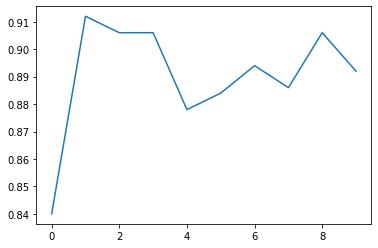

In [126]:
inf_rate = INFECTED_LIST[-10:] ## get the last value of the list
## mean infection rate only taking the last T_TRANS periods 
time_range = np.arange(start = 0, stop = len(inf_rate))
#betas = np.linspace(0,BETA, len(inf_rate))
plt.plot(time_range,inf_rate)
## the plot for BETA and the average inf_rate 
print(f"For BETA = {BETA} and Average rho = {np.mean(inf_rate):.2f}")

In [ ]:
## Makes the animation 
## Expects all images to be in the PATH_IN folder
def make_animation():
    import glob
    from PIL import Image
    # filepaths
    PATH_IN = "./imgs/*.png"
    PATH_OUT = f"./imgs/animation/Erdos_Renyi_SIS_{N}_{P}_{MU}_{BETA}.gif"
    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    imgs = (Image.open(f) for f in sorted(glob.glob(PATH_IN)))
    img = next(imgs)  # extract first image from iterator
    img.save(fp=PATH_OUT, format='GIF', append_images=imgs,
            save_all=True, duration=300, loop=0)
make_animation()

In [ ]:
## MAKE A TAR FILE, Especially for the final delivery 
import tarfile
import os.path

def make_tarfile(output_filename:str, source_dir:str):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
    tar.close()

## Compressing the images 
make_tarfile(f"./imgs/Erdos_Renyi_SIS_{N}_{P}_{MU}_{BETA}.tar.gz",f"./imgs")

In [ ]:
## Display the GIF / Animation in Jupyter Notebook
from IPython.display import Image, display
GIF = f"./imgs/animation/Erdos_Renyi_SIS_{N}_{P}_{MU}_{BETA}.gif"
with open(GIF,'rb') as f:
    display(Image(data=f.read(), format='png',width=500,height=500))